# Introduction: Manual Feature Engineering (part two)

In this notebook we will expand on the [Introduction to Manual Feature Engineering](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output) notebook. We will use the aggregation and value counting functions developed in that notebook in order to incorporate information from the `previous_application`, `POS_CASH_balance`, `installments_payments`, and `credit_card_balance` data files. We already used the information from the `bureau` and `bureau_balance` in the previous notebook and were able to improve our competition score compared to using only the `application` data. After running a model with the features included here, performance does increase, but we run into issues with an explosion in the number of features! I'm working on a notebook of feature selection, but for this notebook we will continue building up a rich set of data for our model. 

The definitions of the four additional data files are:

* previous_application (called `previous`): previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* POS_CASH_BALANCE (called `cash`): monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance (called `credit`): monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment (called `installments`): payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

# Functions 

We spent quite a bit of time developing two functions in the previous notebook:

* `agg_numeric`: calculate aggregation statistics (`mean`, `count`, `max`, `min`) for numeric variables.
* `agg_categorical`: compute counts and normalized counts of each category in a categorical variable.

Together, these two functions can extract information about both the numeric and categorical data in a dataframe. Our general approach will be to apply both of these functions to the dataframes, grouping by the client id, `SK_ID_CURR`. For the `POS_CASH_balance`, `credit_card_balance`, and `installment_payments`, we can first group by the `SK_ID_PREV`, the unique id for the previous loan. Then we will group the resulting dataframe by the `SK_ID_CURR` to calculate the aggregation statistics for each client across all of their previous loans. If that's a little confusing, I'd suggest heading back to the [first feature engineering notebook](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output).**

In [37]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Memory management
import gc 

## Function to Aggregate Numeric Data

This groups data by the `group_var` and calculates `mean`, `max`, `min`, and `sum`. It will only be applied to numeric data by default in pandas.

In [38]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

### Function to Calculate Categorical Counts

This function calculates the occurrences (counts) of each category in a categorical variable for each client. It also calculates the normed count, which is the count for a category divided by the total counts for all categories in a categorical variable. 

In [39]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

### Function for KDE Plots of Variable

We also made a function that plots the distribution of variable colored by the value of `TARGET` (either 1 for did not repay the loan or 0 for did repay the loan). We can use this function to visually examine any new variables we create. This also calculates the correlation cofficient of the variable with the target which can be used as an approximation of whether or not the created variable will be useful. 

In [40]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)
    

# Function to Convert Data Types

This will help reduce memory usage by using more efficient types for the variables. For example `category` is often a better type than `object` (unless the number of unique categories is close to the number of rows in the dataframe).

In [41]:
import sys

def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

Let's deal with one dataframe at a time. First up is the `previous_applications`. This has one row for every previous loan a client had at Home Credit. A client can have multiple previous loans which is why we need to aggregate statistics for each client.

### previous_application

In [42]:
previous = pd.read_csv('../home-credit-default-risk/previous_application.csv')
previous = convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.18 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 80)


,previous_DAYS_DECISION_sum,previous_DAYS_DECISION_min,previous_DAYS_DECISION_mean,previous_DAYS_DECISION_max,previous_DAYS_FIRST_DUE_sum,previous_DAYS_FIRST_DUE_min,previous_DAYS_FIRST_DUE_mean,previous_DAYS_FIRST_DUE_max,previous_DAYS_LAST_DUE_sum,previous_DAYS_LAST_DUE_min,...,previous_DAYS_FIRST_DRAWING_min,previous_DAYS_FIRST_DRAWING_mean,previous_DAYS_FIRST_DRAWING_max,previous_DAYS_FIRST_DRAWING_sum,previous_RATE_INTEREST_PRIMARY_min,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIMARY_max,previous_RATE_INTEREST_PRIVILEGED_min,previous_RATE_INTEREST_PRIVILEGED_mean,previous_RATE_INTEREST_PRIVILEGED_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-1740,-1740,-1740.0,-1740,-1709.0,-1709.0,-1709.000000,-1709.0,-1619.0,-1619.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100002,-606,-606,-606.0,-606,-565.0,-565.0,-565.000000,-565.0,-25.0,-25.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100003,-3915,-2341,-1305.0,-746,-3823.0,-2310.0,-1274.333374,-716.0,-3163.0,-1980.0,...,365243.0,365243.0,365243.0,1095729.0,NaN,NaN,NaN,NaN,NaN,NaN
100004,-815,-815,-815.0,-815,-784.0,-784.0,-784.000000,-784.0,-724.0,-724.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN
100005,-1072,-757,-536.0,-315,-706.0,-706.0,-706.000000,-706.0,-466.0,-466.0,...,365243.0,365243.0,365243.0,365243.0,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Calculate value counts for each categorical column
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


We can join the calculated dataframe to the main training dataframe using a merge. Then we should delete the calculated dataframes to avoid using too much of the kernel memory.

In [45]:
train = pd.read_csv('../home-credit-default-risk/application_train.csv')
train = convert_types(train)
test = pd.read_csv('../home-credit-default-risk/application_test.csv')
test = convert_types(test)

# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

0

We are going to have to be careful about calculating too many features. We don't want to overwhelm the model with too many irrelevant features or features with too many missing values. In the previous notebook, we removed any features with more than 75% missing values. To be consistent, we will apply that same logic here. 

## Function to Calculate Missing Values

In [46]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df, print_info = False):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        if print_info:
            # Print some summary information
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [47]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [48]:
train, test = remove_missing_columns(train, test)

There are 6 columns with greater than 90% missing values.


# Applying to More Data

### Function to Aggregate Stats at the Client Level

In [49]:
def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

## Monthly Cash Data

In [50]:
cash = pd.read_csv('../home-credit-default-risk/POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)
cash.head()

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.41 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [51]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,client_cash_MONTHS_BALANCE_sum_sum,client_cash_MONTHS_BALANCE_min_sum,client_cash_MONTHS_BALANCE_mean_sum,client_cash_MONTHS_BALANCE_max_sum,client_cash_MONTHS_BALANCE_sum_min,client_cash_MONTHS_BALANCE_sum_mean,client_cash_MONTHS_BALANCE_sum_max,client_cash_MONTHS_BALANCE_min_min,client_cash_MONTHS_BALANCE_mean_min,client_cash_MONTHS_BALANCE_max_min,...,client_cash_CNT_INSTALMENT_FUTURE_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_sum_sum,client_cash_CNT_INSTALMENT_min_sum,client_cash_CNT_INSTALMENT_mean_sum,client_cash_CNT_INSTALMENT_max_sum,client_cash_CNT_INSTALMENT_count_sum,client_cash_CNT_INSTALMENT_FUTURE_count_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_sum,client_cash_CNT_INSTALMENT_FUTURE_sum_sum,client_cash_CNT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-2887,-669,-653.0,-637,-378,-320.777778,-275,-96,-94.5,-93,...,28.0,32.0,36.0,36.000000,36.0,41,41,41,62.0,164.0
100002,-3610,-361,-190.0,-19,-190,-190.000000,-190,-19,-10.0,-1,...,456.0,361.0,456.0,456.000000,456.0,361,361,361,5415.0,8664.0
100003,-13240,-1348,-1226.0,-1104,-858,-472.857143,-172,-77,-71.5,-66,...,288.0,256.0,248.0,283.000000,288.0,272,272,272,1608.0,2840.0
100004,-408,-108,-102.0,-96,-102,-102.000000,-102,-27,-25.5,-24,...,16.0,12.0,12.0,15.000000,16.0,16,16,16,36.0,60.0
100005,-2420,-275,-220.0,-165,-220,-220.000000,-220,-25,-20.0,-15,...,132.0,99.0,99.0,128.699997,132.0,110,110,121,792.0,1287.0


In [52]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

Cash by Client Shape:  (337252, 165)


0

In [53]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


## Monthly Credit Data

In [54]:
credit = pd.read_csv('../home-credit-default-risk/credit_card_balance.csv')
credit = convert_types(credit, print_info = True)
credit.head()

Original Memory Usage: 0.71 gb.
New Memory Usage: 0.42 gb.


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [55]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,client_credit_MONTHS_BALANCE_sum_sum,client_credit_MONTHS_BALANCE_min_sum,client_credit_MONTHS_BALANCE_mean_sum,client_credit_MONTHS_BALANCE_sum_min,client_credit_MONTHS_BALANCE_sum_mean,client_credit_MONTHS_BALANCE_sum_max,client_credit_MONTHS_BALANCE_max_sum,client_credit_MONTHS_BALANCE_min_min,client_credit_MONTHS_BALANCE_min_mean,client_credit_MONTHS_BALANCE_min_max,...,client_credit_AMT_DRAWINGS_ATM_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_mean_min,client_credit_AMT_PAYMENT_CURRENT_mean_mean,client_credit_AMT_PAYMENT_CURRENT_mean_max,client_credit_AMT_PAYMENT_CURRENT_max_min,client_credit_AMT_PAYMENT_CURRENT_max_mean,client_credit_AMT_PAYMENT_CURRENT_max_max,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_min,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean,client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,-126,-36,-21.0,-21,-21.0,-21,-6,-6,-6.0,-6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,-210826,-5550,-2849.0,-2849,-2849.0,-2849,-148,-75,-75.0,-75,...,2432.432373,4843.063965,4843.063965,4843.063965,55485.0,55485.0,55485.0,180000.0,180000.0,180000.0
100013,-446976,-9216,-4656.0,-4656,-4656.0,-4656,-96,-96,-96.0,-96,...,6350.000000,7168.346191,7168.346191,7168.346191,153675.0,153675.0,153675.0,157500.0,157500.0,157500.0
100021,-2890,-306,-170.0,-170,-170.0,-170,-34,-18,-18.0,-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100023,-480,-88,-60.0,-60,-60.0,-60,-32,-11,-11.0,-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

Credit by client shape:  (103558, 381)


0

In [57]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


### Installment Payments

In [58]:
installments = pd.read_csv('../home-credit-default-risk/installments_payments.csv')
installments = convert_types(installments, print_info = True)
installments.head()

Original Memory Usage: 0.87 gb.
New Memory Usage: 0.49 gb.


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [59]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,client_installments_DAYS_ENTRY_PAYMENT_sum_sum,client_installments_DAYS_INSTALMENT_sum_sum,client_installments_DAYS_ENTRY_PAYMENT_min_sum,client_installments_DAYS_INSTALMENT_min_sum,client_installments_DAYS_ENTRY_PAYMENT_mean_sum,client_installments_DAYS_INSTALMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_max_sum,client_installments_DAYS_INSTALMENT_max_sum,client_installments_DAYS_INSTALMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_sum_min,...,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_INSTALMENT_min_sum,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_INSTALMENT_sum_max,client_installments_AMT_PAYMENT_mean_sum,client_installments_AMT_INSTALMENT_mean_sum,client_installments_AMT_INSTALMENT_max_sum,client_installments_AMT_PAYMENT_max_sum,client_installments_AMT_PAYMENT_sum_sum,client_installments_AMT_INSTALMENT_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-52813.0,-52598.0,-15608.0,-15584.0,-15365.0,-15314.0,-15080.0,-15044.0,-8658.0,-8647.0,...,2.774678e+04,2.774678e+04,2.925090e+04,2.925090e+04,4.119593e+04,4.119593e+04,8.153775e+04,8.153775e+04,1.528387e+05,1.528387e+05
100002,-113867.0,-106495.0,-11153.0,-10735.0,-5993.0,-5605.0,-931.0,-475.0,-5605.0,-5993.0,...,1.757837e+05,1.757837e+05,2.196257e+05,2.196257e+05,2.196257e+05,2.196257e+05,1.008781e+06,1.008781e+06,4.172888e+06,4.172888e+06
100003,-367137.0,-365546.0,-37757.0,-37514.0,-34633.0,-34454.0,-31594.0,-31394.0,-25740.0,-25821.0,...,1.154108e+06,1.154108e+06,1.150977e+06,1.150977e+06,1.618865e+06,1.618865e+06,4.394102e+06,4.394102e+06,1.134881e+07,1.134881e+07
100004,-6855.0,-6786.0,-2385.0,-2352.0,-2285.0,-2262.0,-2181.0,-2172.0,-2262.0,-2285.0,...,1.607175e+04,1.607175e+04,2.128846e+04,2.128846e+04,2.128846e+04,2.128846e+04,3.172189e+04,3.172189e+04,6.386539e+04,6.386539e+04
100005,-49374.0,-47466.0,-6624.0,-6354.0,-5486.0,-5274.0,-4230.0,-4194.0,-5274.0,-5486.0,...,4.331880e+04,4.331880e+04,5.616184e+04,5.616184e+04,5.616184e+04,5.616184e+04,1.589062e+05,1.589062e+05,5.054566e+05,5.054566e+05


In [60]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape:  (339587, 106)


0

In [61]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 90% missing values.


In [62]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (307511, 1133)
Final Testing Shape:  (48744, 1132)


In [63]:
print(f'Final training size: {return_size(train)}')
print(f'Final testing size: {return_size(test)}')

Final training size: 2.16
Final testing size: 0.34


 #### Save All Newly Calculated Features
 
 Unfortunately, saving all the created features does not work in a Kaggle notebook. You will have to run the code on your personal machine. I have run the code and uploaded the [entire datasets here](https://www.kaggle.com/willkoehrsen/home-credit-manual-engineered-features). I plan on doing some feature selection and uploading reduced versions of the datasets. Right now, they are slightly to big to handle in Kaggle notebooks or scripts. .

In [64]:
# train.to_csv('../home-credit-default-risk/train_previous_raw.csv', index = False, chunksize = 500)
# test.to_csv('../home-credit-default-risk/test_previous_raw.csv', index = False)

## Modeling
<font color="#dd0000">**The model can hardly be fitted due to the scale of data**</font><br /> 

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('../home-credit-default-risk/train_previous_raw.csv')
# test = pd.read_csv('../home-credit-default-risk/test_previous_raw.csv')

In [104]:
def preprocess(train,test = None):
    
    train_labels = train['TARGET']
    train = train.drop(columns=['TARGET','SK_ID_CURR'])
    # test = test.drop(columns = ['SK_ID_CURR'])
    
    train = pd.get_dummies(train)
#     test = pd.get_dummies(test)
    print('Dummy Variables Done')
    
    train_features = list(train.columns)
    
    fill_median = train.dropna(axis = 0).median()
    train = train.fillna(fill_median, axis = 0)
#     test = test.fillna(fill_median, axis = 0)
    print('Fillna Done')
    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    # test = scaler.transform(test)
    print('Scaling Done')
    
    print('Training data shape: ',train.shape)
    # print('Testing data shape: ',test.shape)
    
    from sklearn.model_selection import train_test_split
    X_train,X_val,y_train,y_val = train_test_split(train, train_labels, test_size = 0.2)
    
    X_train = pd.DataFrame(X_train)
    X_train.columns = train_features
    X_train['TARGET'] = y_train
    
    X_val = pd.DataFrame(X_val)
    X_val.columns = train_features
    X_val['TARGET'] = y_val
    print('Train Test Split Done')
    
    print('X_train shape:', X_train.shape)
    print('X_val shape: ',X_val.shape)
    
    X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
    X_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_val.columns]
    
    X_train.to_csv('D:/home-credit-default-risk/train.csv', index = False, chunksize = 5000)
    X_val.to_csv('D:/home-credit-default-risk/val.csv', index = False, chunksize = 5000)

In [5]:
# train_labels = train['TARGET']
# train = train.drop(columns=['TARGET','SK_ID_CURR'])
# # test = test.drop(columns = ['SK_ID_CURR'])

In [6]:
# train = pd.get_dummies(train)
# # test = pd.get_dummies(test)
# print('Dummy Variables Done')

Dummy Variables Done


In [8]:
# train_features = list(train.columns)

In [9]:
# fill_median = train.dropna(axis = 0).median()
# train = train.fillna(fill_median, axis = 0)
# print('Fillna Done')

Fillna Done


In [10]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(train)
# train = scaler.transform(train)
# # test = scaler.transform(test)
# print('Scaling Done')

Scaling Done


In [11]:
# print('Training data shape: ',train.shape)
# # print('Testing data shape: ',test.shape)

Training data shape:  (307511, 1255)


In [12]:
# pd.DataFrame(train).to_csv('D:/home-credit-default-risk/train_to_be_split.csv', index = False, chunksize = 5000)

In [59]:
# # train = pd.read_csv('D:/home-credit-default-risk/train_to_be_split.csv')

In [85]:
# from sklearn.model_selection import train_test_split
# X_train,X_val,y_train,y_val = train_test_split(train, train_labels, test_size = 0.2)

In [86]:
# X_train = pd.DataFrame(X_train)
# X_train.columns = train_features
# X_train['TARGET'] = y_train

In [87]:
# X_val = pd.DataFrame(X_val)
# X_val.columns = train_features
# X_val['TARGET'] = y_val

In [88]:
# print('X_train shape:', X_train.shape)
# print('X_val shape: ',X_val.shape)

X_train shape: (246008, 1256)
X_val shape:  (61503, 1256)


In [89]:
# X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
# X_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_val.columns]

In [96]:
# X_train.to_csv('D:/home-credit-default-risk/train.csv', index = False, chunksize = 5000)
# X_val.to_csv('D:/home-credit-default-risk/val.csv', index = False, chunksize = 5000)

## Incremental Training

In [97]:
import lightgbm as lgb
# The first step is to initialize the model as None and set the model parameters.
gbm=None
params = {
        'task': 'train',
        'application': 'binary',
        'metric':'auc',
        'is_unbalance': 'True', 
        'learning_rate': '0.05', 
        'reg_alpha': '0.1',
        'reg_lambda': '0.1', 
        'subsample': '0.8',
        'n_jobs': '4',
        'device_type': 'cpu'
    }

# The second step is streaming data (100,000 at a time)

i=1
size = 60000
for sub_data in pd.read_csv('D:/home-credit-default-risk/train.csv', chunksize=size):
    
    print('\nCum Training Data: {} records\n'.format(i*size))
    
    x_cols = list(X_train.columns)[:-1]
    y_cols = 'TARGET'
    
    # 区分特征x和结果Y
    x_data = sub_data[x_cols]
    y_data = sub_data[y_cols]

    # 创建lgb的数据集
    lgb_train = lgb.Dataset(x_data, y_data.values)
    lgb_eval = lgb.Dataset(X_val[x_cols], X_val[y_cols].values, reference=lgb_train)

    # Step 3: Incremental Training Model
    # Emphasis is laid on incremental training through init_model and keep_training_booster parameters.
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=lgb_eval,
                    init_model=gbm,             # If gbm is not None, then it is on the basis of the last training.
                    feature_name=x_cols,
                    early_stopping_rounds=10,
                    verbose_eval=False,
                    keep_training_booster=True) # Incremental training

    # Output Model Assessment Score
    print(gbm)
    print('Training set score：auc = %.4f'%(gbm.eval_train()[0][2]))
    print('Val set score：auc = %.4f'%(gbm.eval_valid()[0][2]))
    i += 1


Cum Training Data: 60000 records

Training set score：auc = 0.8822
Val set score：auc = 0.7666

Cum Training Data: 120000 records

Training set score：auc = 0.8153
Val set score：auc = 0.7686

Cum Training Data: 180000 records

Training set score：auc = 0.8094
Val set score：auc = 0.7694

Cum Training Data: 240000 records

Training set score：auc = 0.7877
Val set score：auc = 0.7697

Cum Training Data: 300000 records

Training set score：auc = 0.8755
Val set score：auc = 0.7672


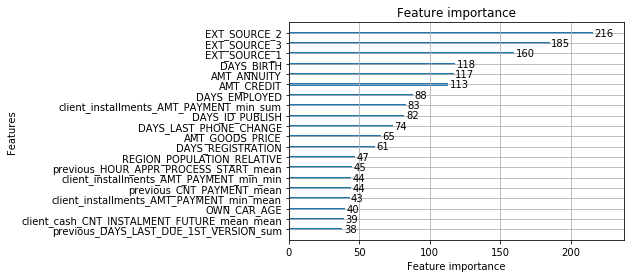

In [105]:
lgb.plot_importance(gbm, max_num_features = 20)